In [1]:
import pymysql
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import scipy.stats as stats
import csv
import matplotlib.colors as mcolors
import os

from statsmodels.stats.multicomp import MultiComparison

# from tidy_data import get_df_afr 
# afr.to_numpy()[1][0:4]

In [2]:
#csv
# afr = pd.read_csv('avaliacao_funcao_renal.csv')

In [3]:
con = pymysql.connect(host="localhost", user="gabic", passwd="1234", db="doenca_renal_cronica")
con.select_db('doenca_renal_cronica')
cursor = con.cursor()  
cursor.connection.autocommit(True)

In [4]:
#criando os dataframes por tabela 
dados_consulta = pd.read_sql('SELECT * FROM doenca_renal_cronica.dados_consulta',con=con)
cidade = pd.read_sql('SELECT * FROM doenca_renal_cronica.cidade',con=con)
ubs = pd.read_sql('SELECT * FROM doenca_renal_cronica.ubs',con=con)
aval_funcao_renal = pd.read_sql('SELECT * FROM doenca_renal_cronica.aval_funcao_renal',con=con)
consulta_has = pd.read_sql('SELECT * FROM doenca_renal_cronica.consulta_has',con=con)
consulta_drc = pd.read_sql('SELECT * FROM doenca_renal_cronica.consulta_drc',con=con)
consulta_dm = pd.read_sql('SELECT * FROM doenca_renal_cronica.consulta_dm',con=con)
calculo_tfg = pd.read_sql('SELECT * FROM doenca_renal_cronica.calculo_tfg',con=con)
preparacao_trs = pd.read_sql('SELECT * FROM doenca_renal_cronica.preparacao_trs',con=con)
raca = pd.read_sql('SELECT * FROM doenca_renal_cronica.raca',con=con)
instrucao = pd.read_sql('SELECT * FROM doenca_renal_cronica.instrucao',con=con)
paciente = pd.read_sql('SELECT * FROM doenca_renal_cronica.paciente',con=con)
exame_fisico = pd.read_sql('SELECT * FROM doenca_renal_cronica.exame_fisico',con=con)
avaliacao_tratamento = pd.read_sql('SELECT * FROM doenca_renal_cronica.avaliacao_tratamento',con=con)
medicamento = pd.read_sql('SELECT * FROM doenca_renal_cronica.medicamento',con=con)
complicacao_funcao_renal = pd.read_sql('SELECT * FROM doenca_renal_cronica.complicacao_funcao_renal',con=con)

#dicionario com todas tabelas
dic = {'dados_consulta':dados_consulta,'cidade':cidade,'ubs':ubs,'aval_funcao_renal':aval_funcao_renal,
       'consulta_has':consulta_has,'consulta_drc':consulta_drc,'consulta_dm':consulta_dm,'calculo_tfg':calculo_tfg,
       'preparacao_trs':preparacao_trs,'raca':raca,'instrucao':instrucao,'paciente':paciente,'exame_fisico':exame_fisico,
       'avaliacao_tratamento':avaliacao_tratamento,'medicamento':medicamento,'complicacao_funcao_renal':complicacao_funcao_renal
      }

In [5]:
dic['dados_consulta'].keys()

Index(['id_dados_consulta', 'data_inicial', 'data_final', 'tempoAcomp',
       'total_consultas_drc', 'total_consultas_dm', 'total_consultas_has',
       'desfecho', 'desfecho_text', 'id_cidade', 'id_afr', 'id_ubs', 'id_has',
       'id_drc', 'id_dm', 'id_cfr', 'id_exame_fisico', 'id_calculo_tfg',
       'id_preparacao_trs', 'id_medicamento', 'id_aval_tratamento', 'estagioI',
       'estagioF', 'estagioI_alb', 'estagioF_alb'],
      dtype='object')

In [6]:
correto={}
meses = ['jan','fev','mar','abr','mai','jun','jul','ago','set','out','nov','dez']
for ind in range(len(dic['aval_funcao_renal']['id_afr'])):
    if dic['paciente']['data_nascimento'][ind]!='0.0':
        data_nascimento = dic['paciente']['data_nascimento'][ind].split('/')
        for i in range(len(meses)):
            if meses[i]==data_nascimento[1]:
                tam = len(meses[0:i])
        correto = str(1900+int(data_nascimento[2]))+'-'+str(tam+1)+'-'+data_nascimento[0]
        dic['paciente']['data_nascimento'][ind] = pd.to_datetime(correto)

/home/gabic9814/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [7]:
#substituindo os valores para Nan 
for tabela in dic:
    for coluna in dic[tabela].keys():
        dic[tabela][coluna]=dic[tabela][coluna].replace([0,'0','0.0',''], np.nan)

In [8]:
for tabela in dic:
    for coluna in dic[tabela].keys():
        i_split = coluna.split('_')
        if i_split[0]=='id':
            dic[tabela]=dic[tabela].drop(columns=[coluna], errors='ignore')
        if i_split[0]=='dt':
            dic[tabela]=dic[tabela].drop(columns=[coluna], errors='ignore')
        if i_split[0]=='total':
            dic[tabela]=dic[tabela].drop(columns=[coluna], errors='ignore')

In [9]:
afr={}
cfr={}
data = pd.read_csv('banco/Dados2010-2014DesfechoFasesETC2.csv')
idade = data['Idade']
id_paciente = data['Id']
for tabela in dic:
    for coluna in dic[tabela].keys():
        if coluna == 'sexo' or coluna=='data_nascimento' or coluna =='estagioI' or coluna=='estagioF' or coluna=='estagioI_alb' or coluna=='estagioF_alb':
            afr[coluna] = dic[tabela][coluna]
            cfr[coluna] = dic[tabela][coluna]
        elif tabela == 'aval_funcao_renal':
            afr[coluna] = dic[tabela][coluna]
        elif tabela == 'complicacao_funcao_renal':
            cfr[coluna] = dic[tabela][coluna]
            
afr['id_paciente'] = id_paciente
cfr['id_paciente'] = id_paciente      
afr['idade'] = idade
cfr['idade'] = idade
df_afr = pd.DataFrame(afr)
df_cfr = pd.DataFrame(cfr)

/home/gabic9814/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (214,222,223,229) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
#tidy data
df_afr=(df_afr.melt(id_vars=["id_paciente","sexo","idade","data_nascimento","estagioI", "estagioF", 'estagioI_alb', 'estagioF_alb'],
                    var_name=["exame"],
                    value_name="valor"))

In [11]:
df_afr['estagioI']= df_afr['estagioI'].replace('1',1)
df_afr['estagioI']= df_afr['estagioI'].replace('2',2)
df_afr['estagioI']= df_afr['estagioI'].replace('3a',31)
df_afr['estagioI']= df_afr['estagioI'].replace('3b',32)
df_afr['estagioI']= df_afr['estagioI'].replace('4',4)
df_afr['estagioI']= df_afr['estagioI'].replace('5',5)

df_afr['estagioF']= df_afr['estagioF'].replace('1',1)
df_afr['estagioF']= df_afr['estagioF'].replace('2',2)
df_afr['estagioF']= df_afr['estagioF'].replace('3a',31)
df_afr['estagioF']= df_afr['estagioF'].replace('3b',32)
df_afr['estagioF']= df_afr['estagioF'].replace('4',4)
df_afr['estagioF']= df_afr['estagioF'].replace('5',5)

In [10]:
colors = mcolors.CSS4_COLORS
# colors

In [11]:
colors.pop('snow', None)
colors.pop('grey', None)
colors.pop('white', None)
colors.pop('whitesmoke', None)
colors.pop('gainsboro', None)
colors.pop('lightgrey', None)
colors.pop('darkgrey', None)
colors.pop('dimgrey', None)
colors.pop('seashell', None)
colors.pop('peachpuff', None)
colors.pop('linen', None)
colors.pop('bisque', None)
colors.pop('tan', None)
colors.pop('antiquewhite', None)
colors.pop('navajowhite', None)
colors.pop('blanchedalmond', None)
colors.pop('oldlace', None)
colors.pop('floralwhite', None)
colors.pop('papayawhip', None)
colors.pop('cornsilk', None)
colors.pop('lemonchiffon', None)
colors.pop('ivory', None)
colors.pop('beige', None)
colors.pop('lightyellow', None)
colors.pop('lightoldenrodyellow', None)
colors.pop('honeydew', None)
colors.pop('mintcream', None)
colors.pop('moccasin', None)
colors.pop('wheat', None)
colors.pop('palegoldenrod', None)
colors.pop('palegreen', None)
colors.pop('azure', None)
colors.pop('ligtcyan', None)
colors.pop('aliceblue', None)
colors.pop('ghostwhite', None)
colors.pop('lavender', None)
colors.pop('lavenderbrush', None)
colors.pop('aqua', None)
colors.pop('ligtsalmon', None)

/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gabic9814/anaconda3/lib/python3

/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gabic9814/anaconda3/lib/python3

/home/gabic9814/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde

/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/gabic9814/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/gabic9814/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/gabic9814/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gabic9814/anaconda3/lib/p

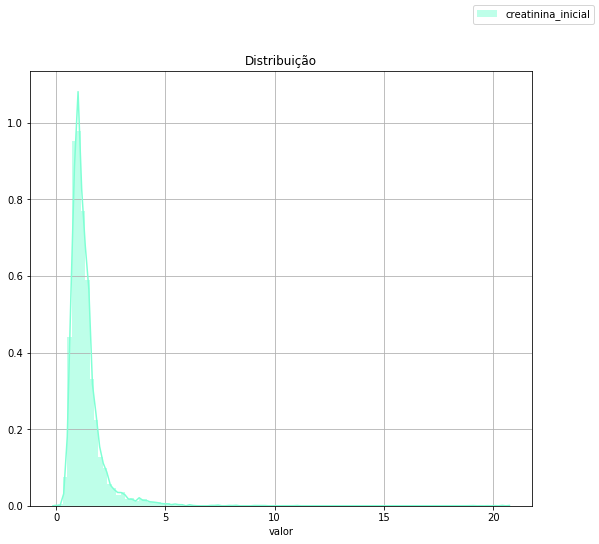

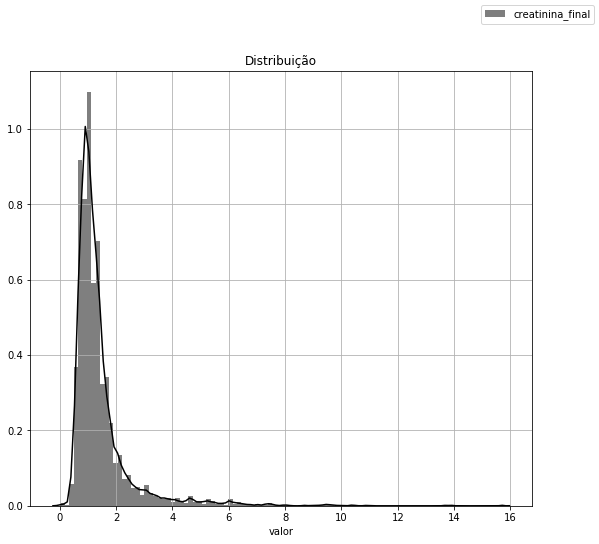

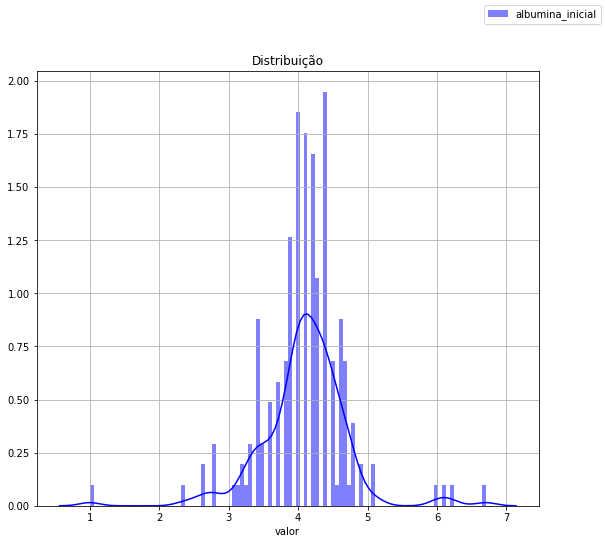

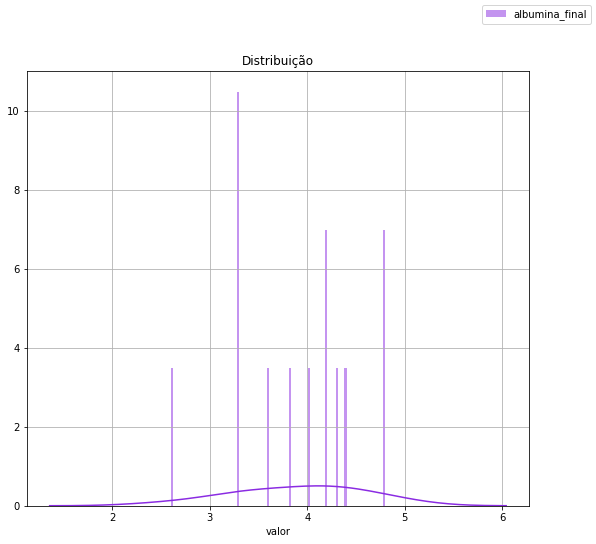

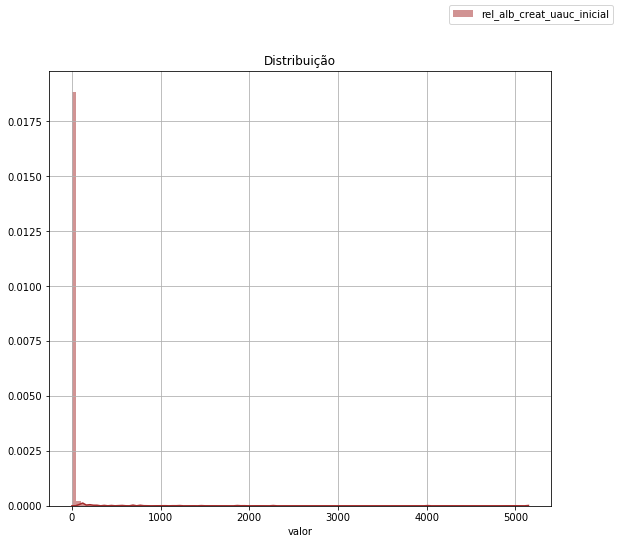

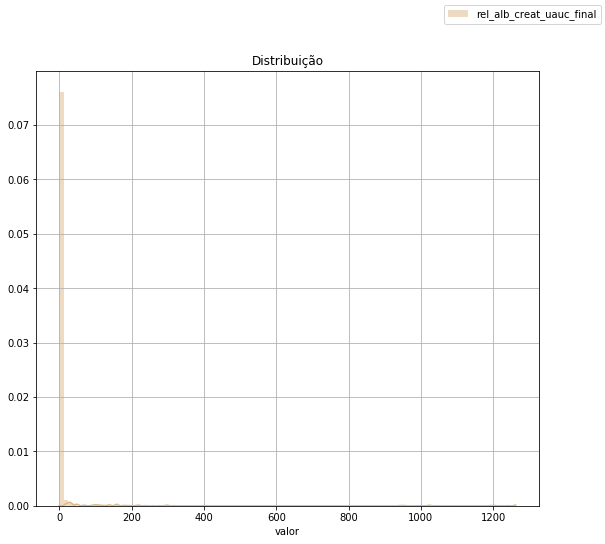

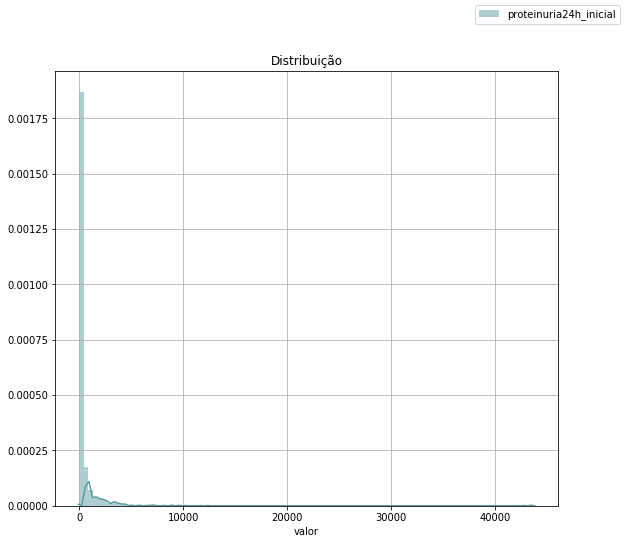

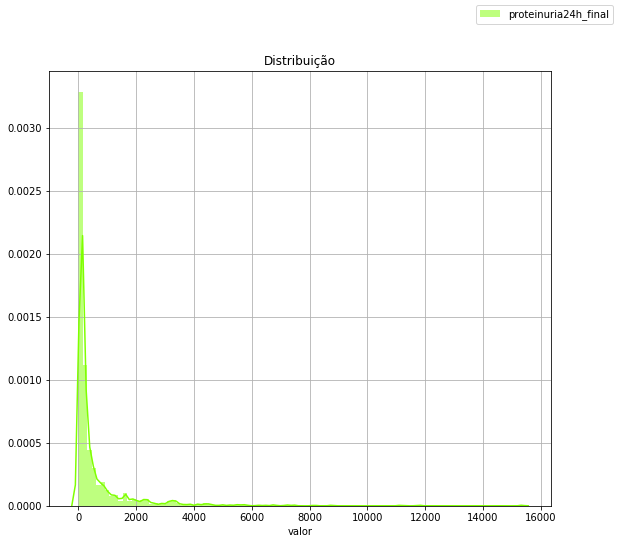

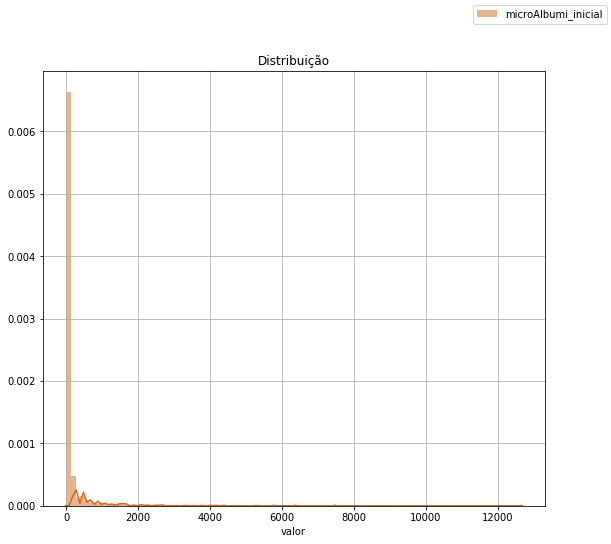

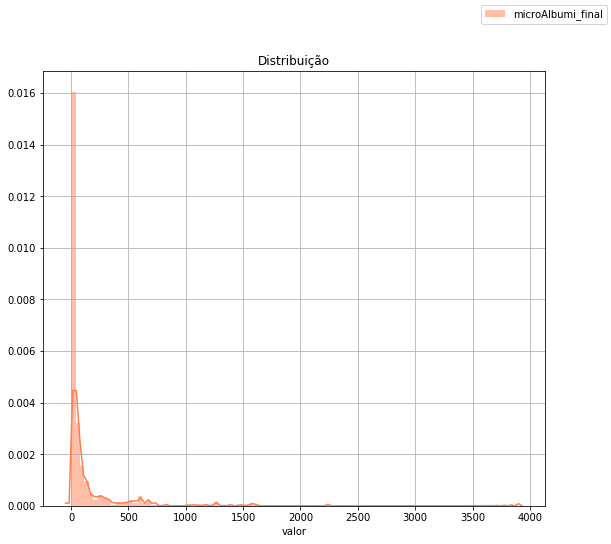

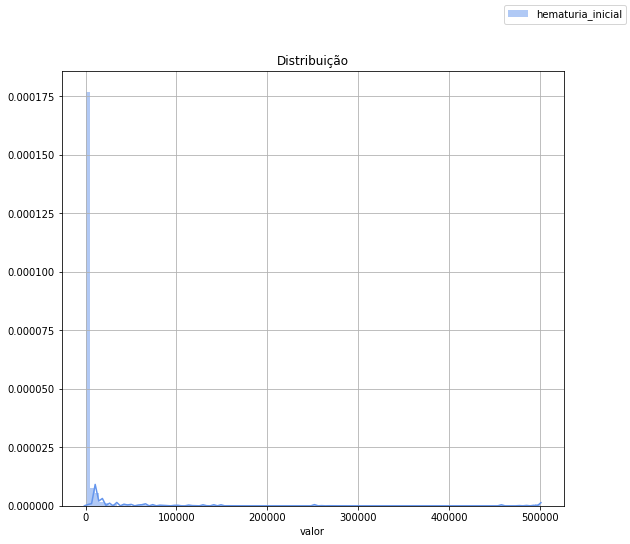

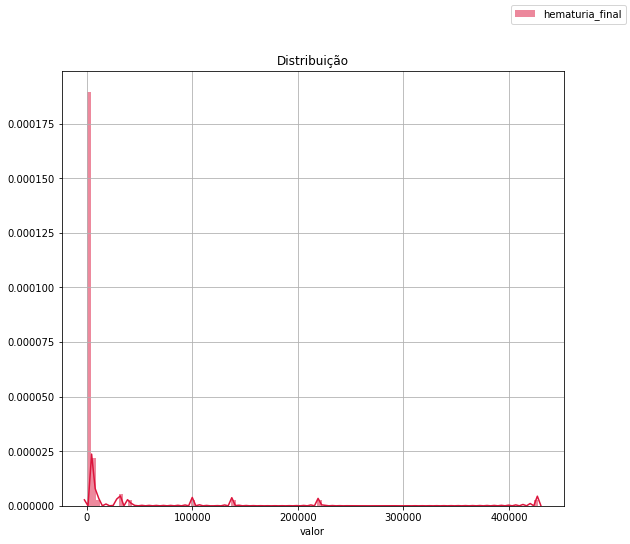

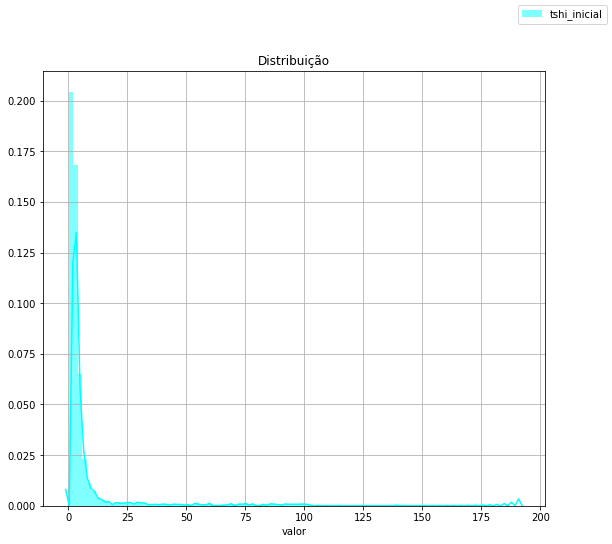

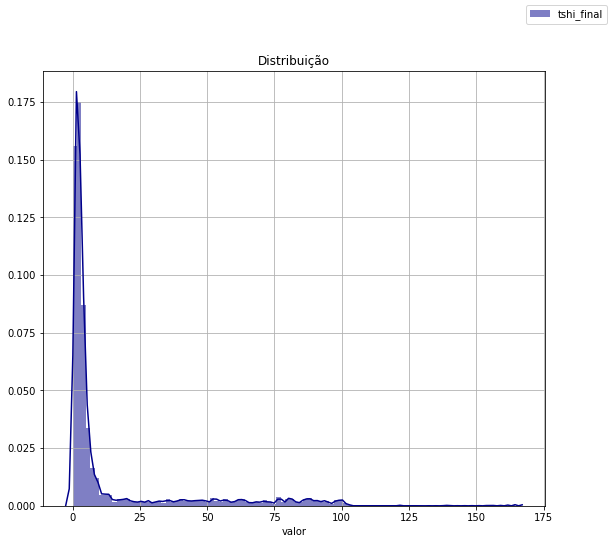

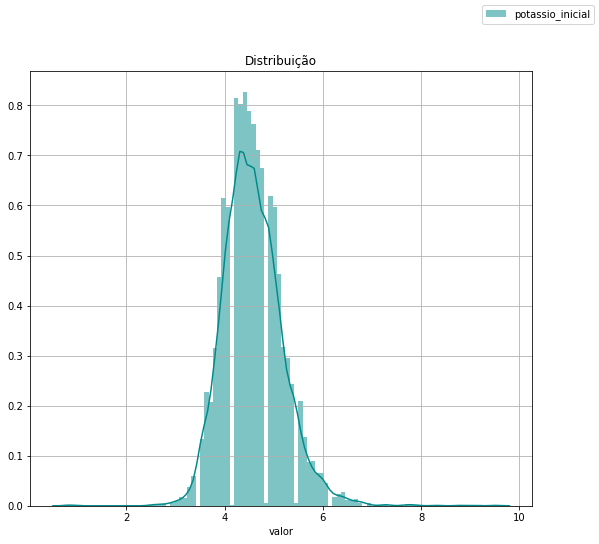

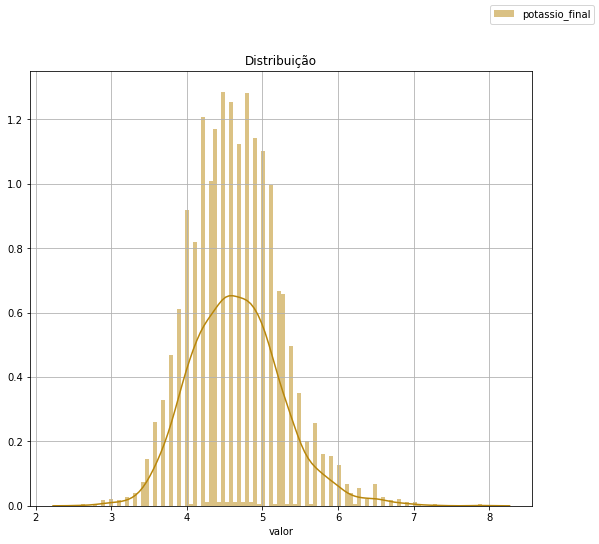

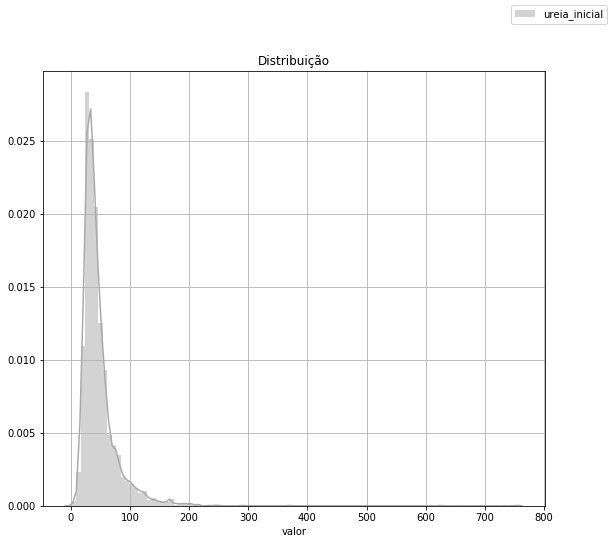

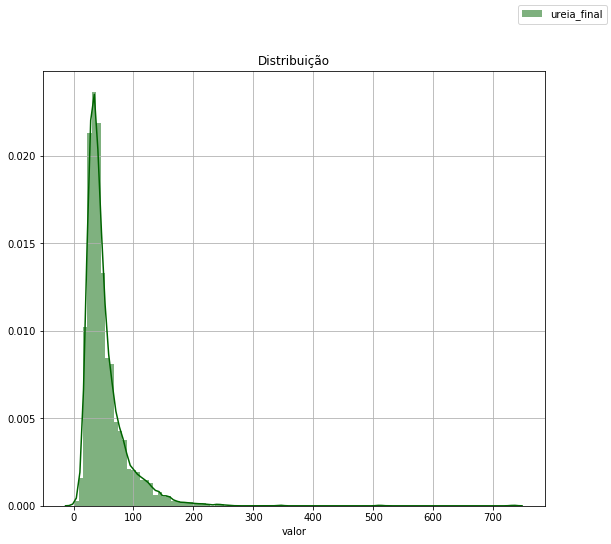

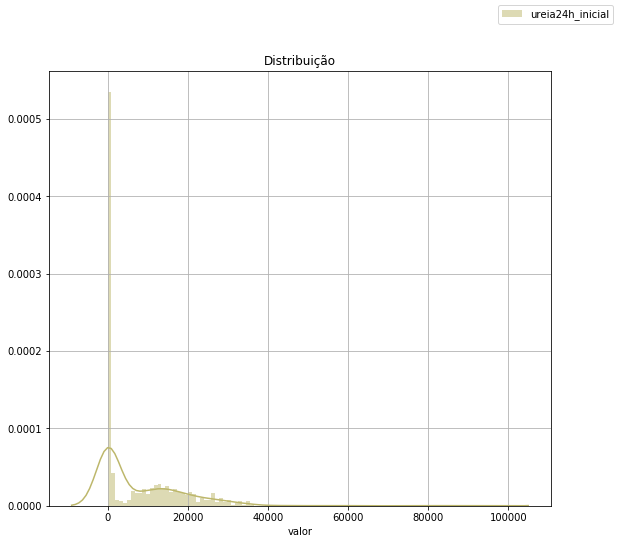

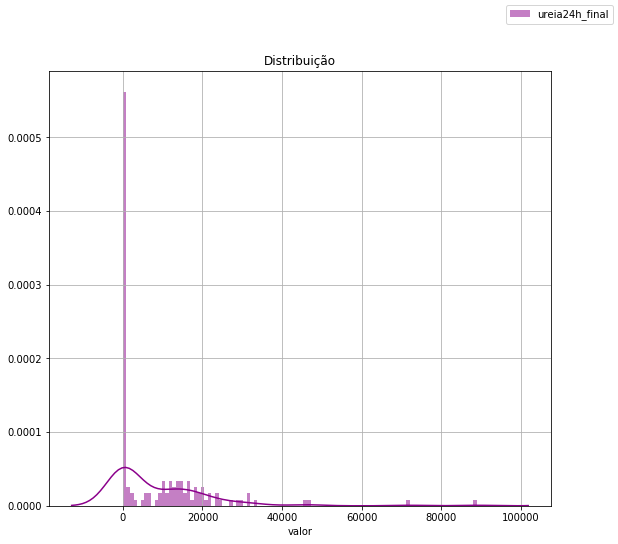

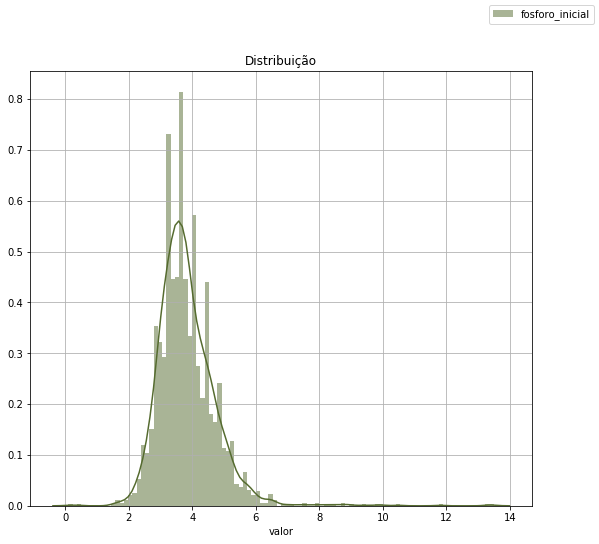

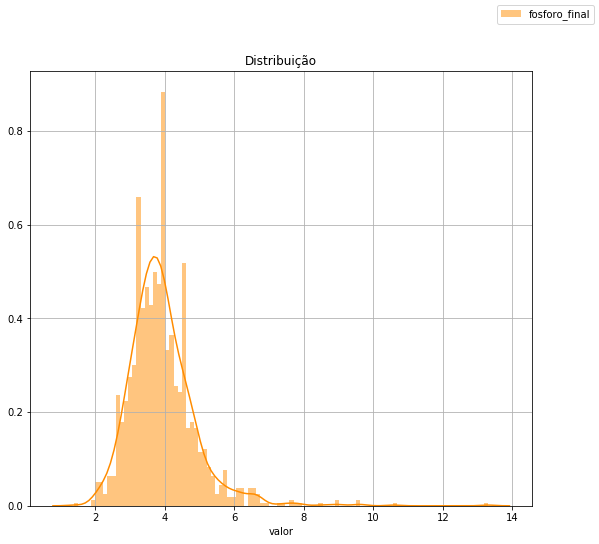

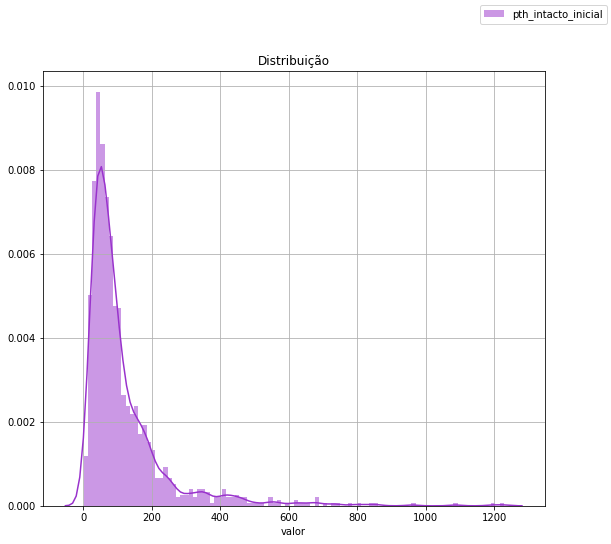

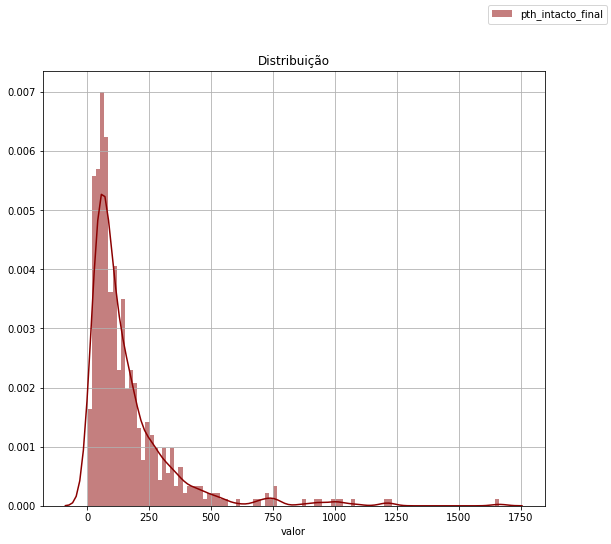

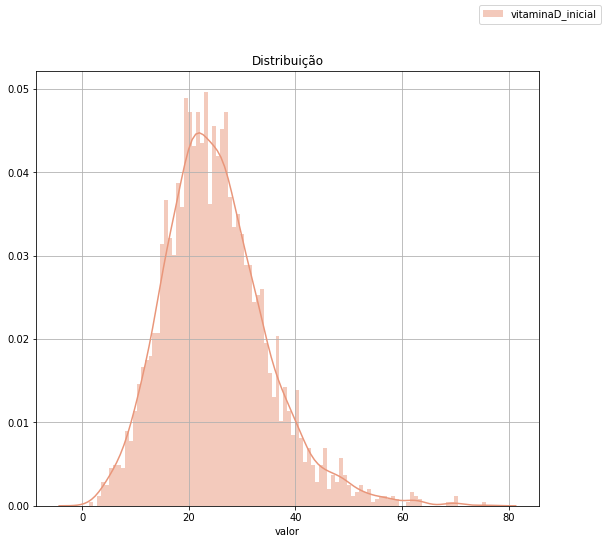

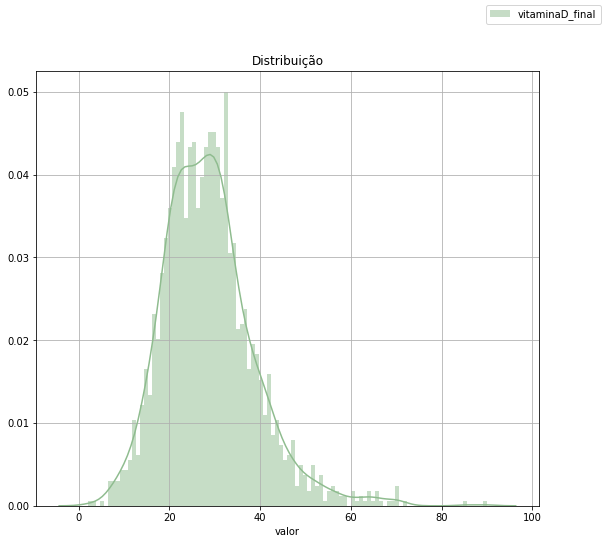

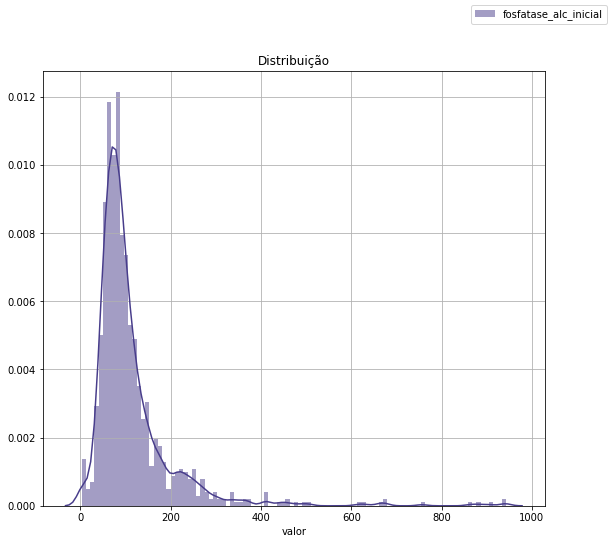

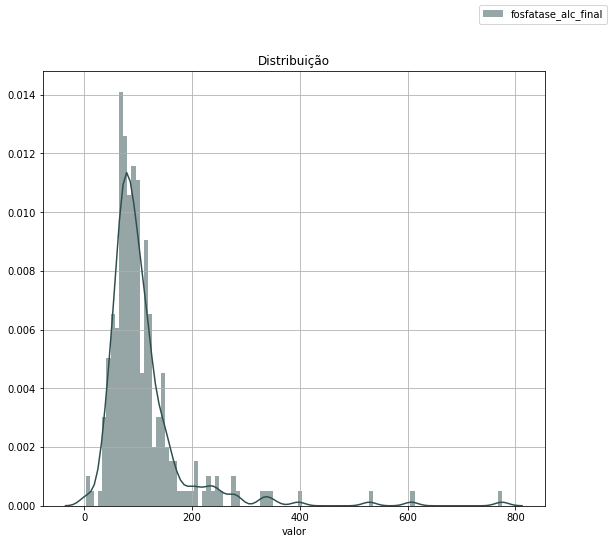

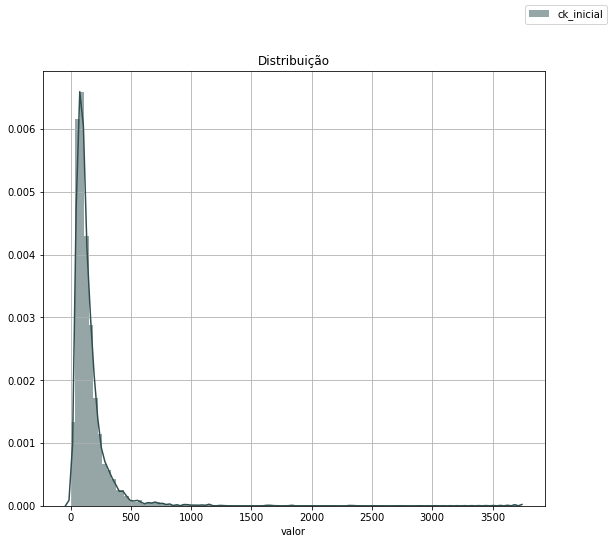

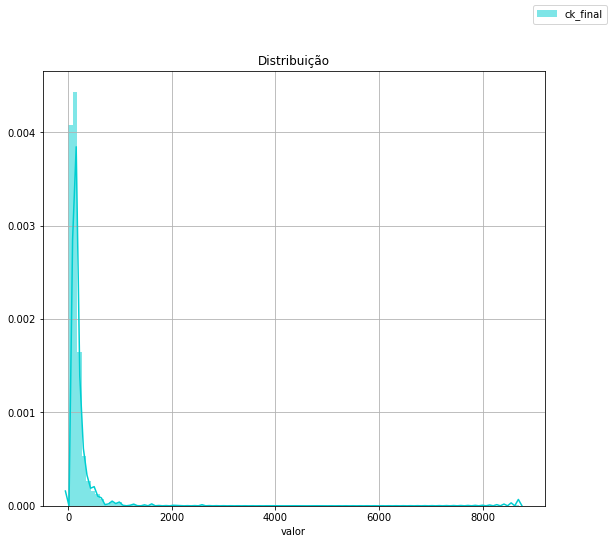

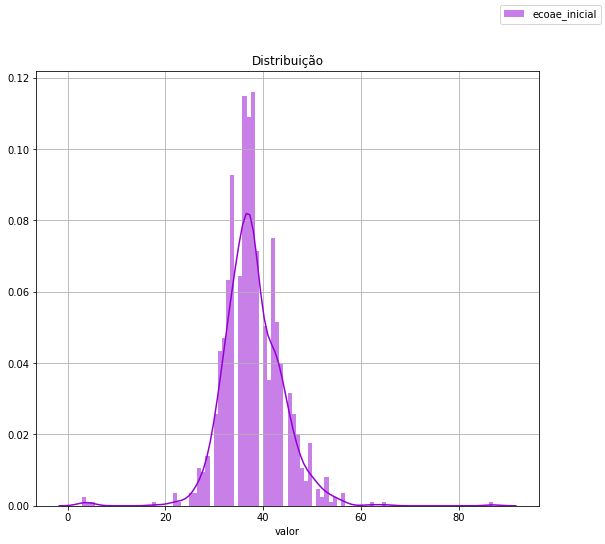

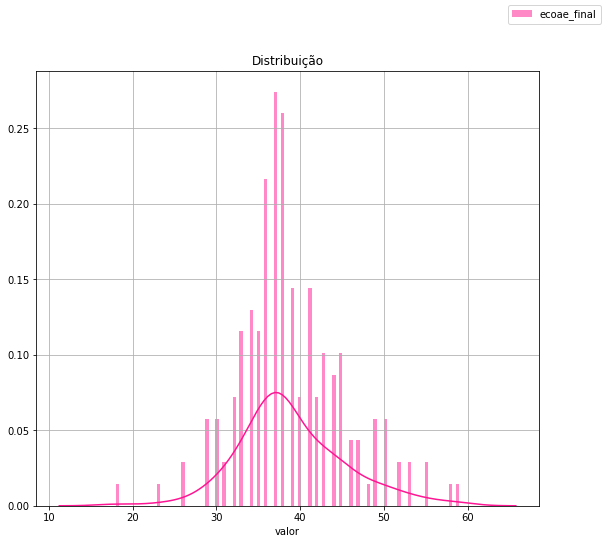

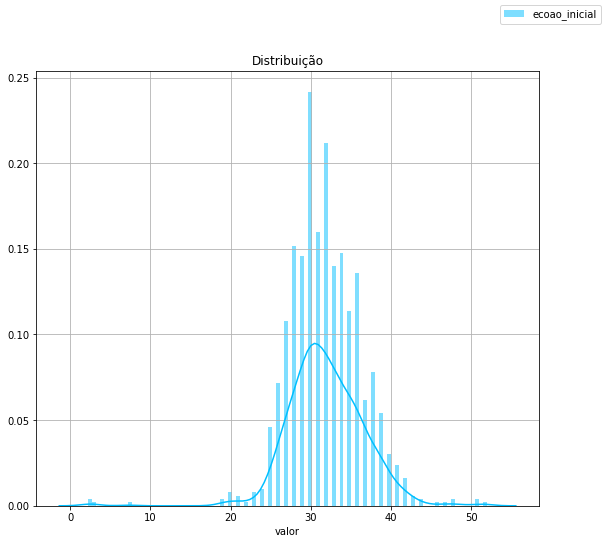

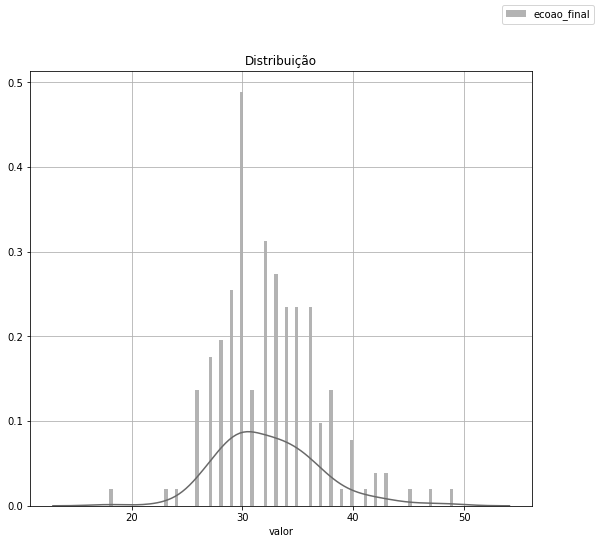

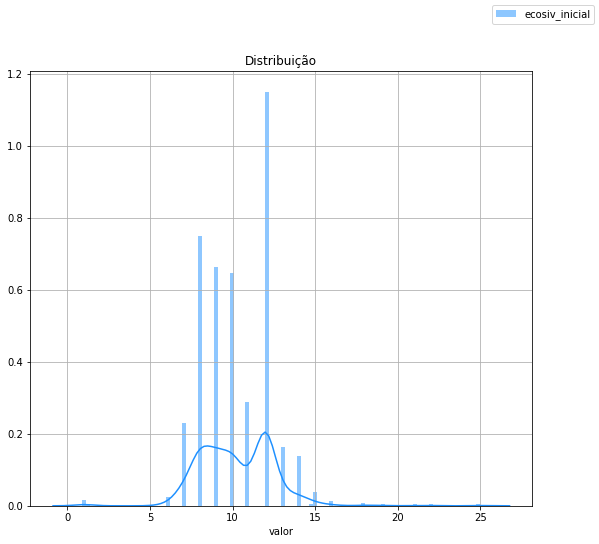

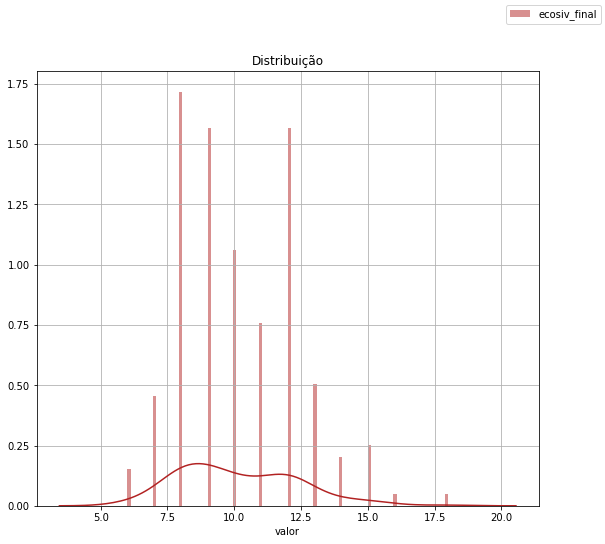

In [12]:
##gráficos de distribuição
colors=list(colors)
nomes_exames =['creatinina_inicial', 'creatinina_final', 'albumina_inicial',
               'albumina_final', 'rel_alb_creat_uauc_inicial',
               'rel_alb_creat_uauc_final', 'proteinuria24h_inicial',
               'proteinuria24h_final', 'microAlbumi_inicial', 'microAlbumi_final',
               'hematuria_inicial', 'hematuria_final', 'tshi_inicial', 'tshi_final',
               'potassio_inicial', 'potassio_final', 'ureia_inicial', 'ureia_final',
               'ureia24h_inicial', 'ureia24h_final', 'fosforo_inicial',
               'fosforo_final', 'pth_intacto_inicial', 'pth_intacto_final',
               'vitaminaD_inicial', 'vitaminaD_final', 'fosfatase_alc_inicial',
               'fosfatase_alc_final', 'ck_inicial', 'ck_final', 'ecoae_inicial',
               'ecoae_final', 'ecoao_inicial', 'ecoao_final', 'ecosiv_inicial',
               'ecosiv_final']
# os.mkdir('/home/gabic9814/git/DRC/distribuicao_separadas')
for ind in range(len(nomes_exames)):
    fig = plt.figure(figsize=(9, 8))
    plt.grid()
    plt.title('Distribuição')
    sns.distplot(df_afr.loc[df_afr['exame'] == nomes_exames[ind], 'valor'], color=colors[ind], bins=100, hist_kws={'alpha': 0.5});
#     sns.distplot(df_afr.loc[df_afr['exame'] == 'albumina_inicial', 'valor'], color=colors[1], bins=100, hist_kws={'alpha': 0.5});
    # sns.distplot(df_afr.loc[df_afr['exame'] == 'creatinina_final', 'valor'], color=colors[2], bins=100, hist_kws={'alpha': 0.5});
    # sns.distplot(df_afr.loc[df_afr['exame'] == 'creatinina_inicial', 'valor'], color=colors[3], bins=100, hist_kws={'alpha': 0.5});
    fig.legend([nomes_exames[ind],],loc='upper right')
    # plt.show()
#     ,'albumina_inicial'
    plt.savefig("distribuicao_separadas/Distribuicao_"+str(nomes_exames[ind]))

In [13]:
df_afr

,id_paciente,sexo,idade,data_nascimento,estagioI,estagioF,estagioI_alb,estagioF_alb,exame,valor
0,20,Feminino,34.0,1979-08-04,NaN,NaN,NaN,NaN,creatinina_inicial,0.83
1,27,Masculino,74.0,1940-05-29,3a,2,1.0,NaN,creatinina_inicial,1.40
2,28,Feminino,72.0,1941-09-14,NaN,NaN,NaN,NaN,creatinina_inicial,NaN
3,29,Masculino,79.0,1934-12-21,NaN,NaN,NaN,NaN,creatinina_inicial,NaN
4,31,Feminino,69.0,1944-12-05,NaN,NaN,NaN,NaN,creatinina_inicial,NaN
5,32,Masculino,56.0,1957-10-24,NaN,NaN,NaN,NaN,creatinina_inicial,NaN
6,33,Feminino,70.0,1943-12-12,NaN,NaN,NaN,NaN,creatinina_inicial,NaN
7,35,Feminino,50.0,1964-03-26,3a,3a,1.0,1.0,creatinina_inicial,0.60
8,40,Feminino,78.0,1937-04-21,4,3b,NaN,2.0,creatinina_inicial,2.10
9,41,Masculino,65.0,1948-04-17,NaN,NaN,NaN,NaN,creatinina_inicial,NaN


In [14]:
##escreve o arquivo descrição afr
# with open ('descricao_afr.txt','w') as arquivo:
#     for ind in range(len(nomes_exames)):
#         arquivo.write('Nome:'+ nomes_exames[ind]+'\n')
#         arquivo.write(str(df_afr.loc[df_afr['exame'] == nomes_exames[ind], 'valor'].describe()))       
#         arquivo.write('\n')


In [15]:
#dataframe para a descrição 
inserir = []
for ind in range(len(nomes_exames)):
    aux = pd.DataFrame(df_afr.loc[df_afr['exame'] == nomes_exames[ind], 'valor'].describe()) 
#     print(aux)
#     print('\n')
    aux = aux.rename(columns={"valor": nomes_exames[ind]})
    aux = aux.T
#     print(aux)
    inserir.append(aux)
descricao = pd.concat(inserir)
descricao
# inserir

,count,mean,std,min,25%,50%,75%,max
creatinina_inicial,6115.0,1.328741,0.817987,0.10,0.900,1.120,1.500,20.50
creatinina_final,4555.0,1.424654,1.111397,0.02,0.890,1.100,1.500,15.70
albumina_inicial,180.0,4.095556,0.626971,1.00,3.875,4.100,4.400,6.70
albumina_final,13.0,3.896154,0.651224,2.60,3.300,4.020,4.300,4.80
rel_alb_creat_uauc_inicial,2777.0,13.719240,154.132515,0.01,0.060,0.120,0.440,5148.00
rel_alb_creat_uauc_final,1069.0,7.040309,70.142753,0.01,0.070,0.130,0.400,1262.00
proteinuria24h_inicial,2802.0,420.705632,1231.601495,0.01,61.275,127.420,299.900,43700.00
proteinuria24h_final,1322.0,570.676800,1192.743133,0.03,72.000,148.760,480.000,15340.00
microAlbumi_inicial,2018.0,146.917988,551.864140,0.04,7.000,19.220,62.000,12650.00
microAlbumi_final,531.0,116.912486,299.154798,0.01,7.280,21.000,79.000,3883.20


In [16]:
# #adicionando a coluna observações
# observacoes = []
# for ind in range(len(descricao)):
#     if ind==0 or ind==1 or ind==12 or ind==13 or ind==14 or ind==15 or ind==20 or ind==21 or ind==22 or ind==23 or ind==24 or ind==25 or ind==26 or ind==27:
#         observacoes.append('Não precisa inserir dados')
#     elif ind==18 or ind==19:
#         observacoes.append('Possui 2 picos e não precisa adicionar dados')
#     elif ind==3:
#         observacoes.append('13 dados são nulos, não é interessante inserir dados')
#     elif ind==6:
#         observacoes.append('max= 43700(2012-10-10)- id paciente 2445; final deste mesmo paciente foi 256.80(2015-08-06)')
#     elif ind ==7:
#         observacoes.append('max= 15340(2015-11-18)- id paciente 6452; inicial deste mesmo paciente foi 1873(2013-05-23)')
#     elif ind==8:
#         observacoes.append('max= 12650(2014-06-14)- id paciente 8383; final deste mesmo paciente foi 13.20(2014-10-09)')
#     elif ind==9:
#         observacoes.append('max= 3883.20(2014-11-18)- id paciente 5084; inicial deste mesmo paciente foi 3748(2013-02-14)')
#     elif ind==10:
#         observacoes.append('max= 500000(2014-06-16)- id paciente 8518; não tem valor final')
#     elif ind==11:
#         observacoes.append('max= 428000(2012-08-03)- id paciente 5141; inicial deste mesmo paciente foi 251500(2012-07-11)')
#     else:
#         observacoes.append(np.nan)
# descricao['observacoes'] = observacoes       

In [17]:
descricao.to_csv('descricao_afr.csv',index=True)


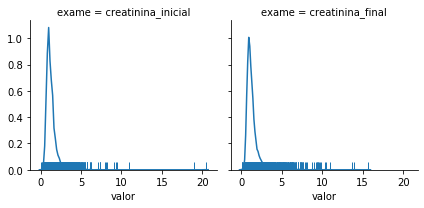

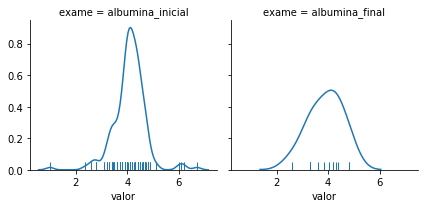

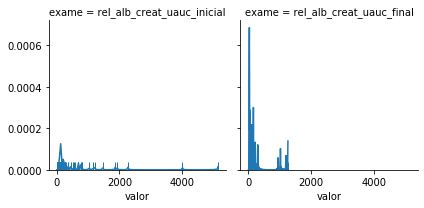

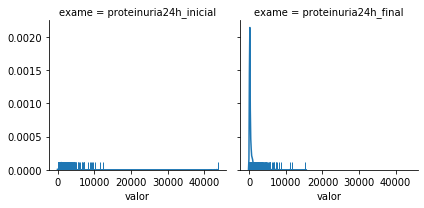

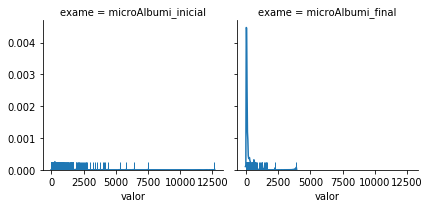

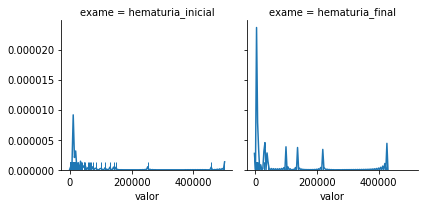

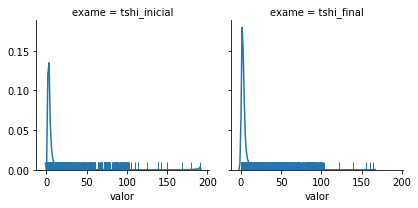

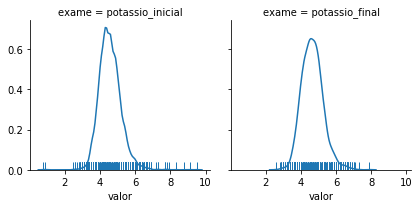

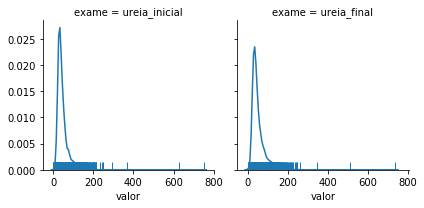

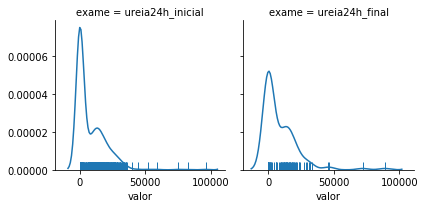

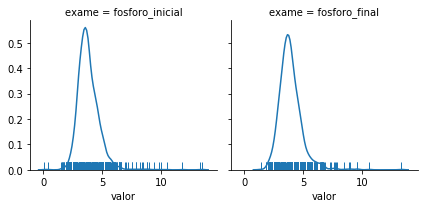

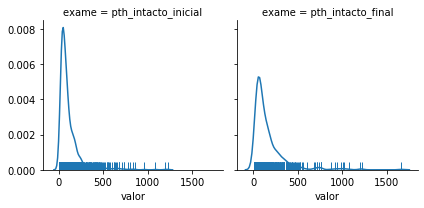

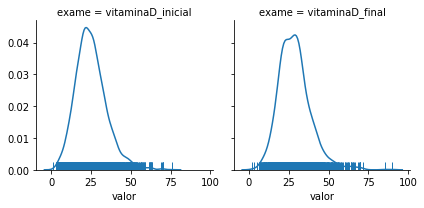

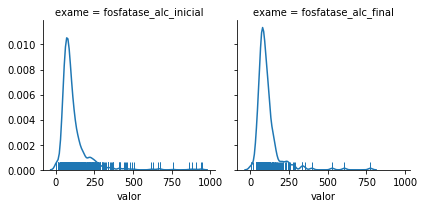

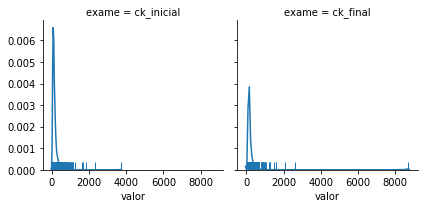

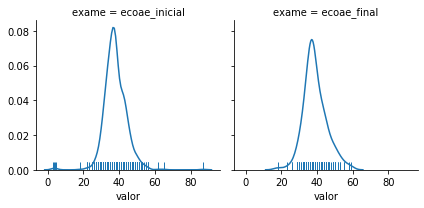

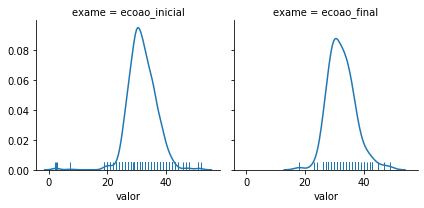

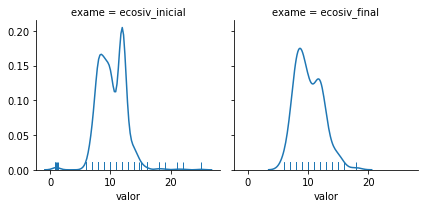

In [20]:
##gráficos de distribuição
# os.mkdir('/home/gabic9814/git/DRC/distribuicao_inicial_final')
ind_parou=0
for ind in range(len(df_afr)):
    exame_nome = df_afr['exame'][ind]
    i_split = exame_nome.split('_')
    if i_split[-1]=='final' and ind+1< len(df_afr["exame"]):
        nome_proximo = df_afr['exame'][ind+1]
        split_proximo =nome_proximo.split('_')
        if split_proximo[-1]=='inicial':
            g = sns.FacetGrid(df_afr[ind_parou:ind+1], col="exame")
            g.map(sns.distplot, "valor", hist=False, rug=True);
            plt.savefig("distribuicao_inicial_final/"+str(exame_nome[:-2]))
            if ind!=0:
                ind_parou = ind+1
    elif ind+1==len(df_afr["exame"]):
        g = sns.FacetGrid(df_afr[ind_parou:ind+1], col="exame")
        g.map(sns.distplot, "valor", hist=False, rug=True);
        plt.savefig("distribuicao_inicial_final/"+str(exame_nome[:-2]))
            
        

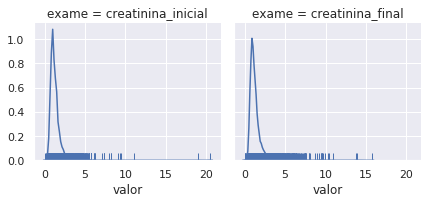

In [83]:
# for ind in range(len(df_afr)):
# exame_nome = df_afr['exame'][ind]
# i_split = exame_nome.split('_')
# if i_split[-1]=='final' and ind+1< len(df_afr["exame"]):
# #         print('não entrei')
# #         print(df_afr['exame'][ind+1])
#     nome_proximo = df_afr['exame'][ind+1]
#     split_proximo = exame_nome.split('_')

#     if split_proximo[-1]=='inicial':
#         print('entrei')
#         ind_parou=0
#         if ind!=0:
#             ind_parou = ind+1
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# fig = plt.figure(figsize=(9, 8))
# plt.grid()
# # plt.title('Distribuição')
# g = sns.FacetGrid(df_afr[0:14531], col="exame")
# g.map(sns.distplot, "valor", hist=False, rug=True);
# #             fig.legend([nomes_exames[ind],],loc='upper right')
# g.add_legend()
# #             plt.show()
# plt.savefig("distribuicao_multiplot/distribuicao_"+str(df_afr['exame'][ind]))